/home/angelika/miniconda3/envs/psplat/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device cuda


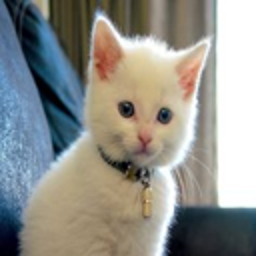

Loading the original state_dicts of the encoder and the decoder...


In [1]:
import requests
from PIL import Image
from io import BytesIO
import torch
import safetensors.torch
from safetensors.torch import load_file, save_file
from diffusers import StableDiffusionUpscalePipeline, AutoencoderTiny
import torchvision.transforms.functional as TF

# From https://huggingface.co/madebyollin/taesd-x4-upscaler

url = "https://huggingface.co/datasets/hf-internal-testing/diffusers-images/resolve/main/sd2-upscale/low_res_cat.png"
low_res_img = Image.open(BytesIO(requests.get(url).content)).convert("RGB").resize((256, 256))

vae = AutoencoderTiny.from_pretrained("madebyollin/taesd-x4-upscaler", torch_dtype=torch.float32)

dev = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print("Using device", dev)
vae = vae.to(dev)

test_image = TF.center_crop(low_res_img, 256)
display(test_image)

# Weights from https://huggingface.co/madebyollin/taesd-x4-upscaler/tree/main
# Load safetensors state_dicts
print("Loading the original state_dicts of the encoder and the decoder...")
encoder_state_dict = load_file("/home/angelika/vae/pretrained_models/taesd_encoder.safetensors")
decoder_state_dict = load_file("/home/angelika/vae/pretrained_models/taesd_decoder.safetensors")


In [2]:
# From https://github.com/madebyollin/taesd/

import torch.nn as nn

def conv(n_in, n_out, **kwargs):
    return nn.Conv2d(n_in, n_out, 3, padding=1, **kwargs)

class Clamp(nn.Module):
    def forward(self, x):
        return torch.tanh(x / 3) * 3

class Block(nn.Module):
    def __init__(self, n_in, n_out):
        super().__init__()
        self.conv = nn.Sequential(conv(n_in, n_out), nn.ReLU(), conv(n_out, n_out), nn.ReLU(), conv(n_out, n_out))
        self.skip = nn.Conv2d(n_in, n_out, 1, bias=False) if n_in != n_out else nn.Identity()
        self.fuse = nn.ReLU()
    def forward(self, x):
        return self.fuse(self.conv(x) + self.skip(x))

def Encoder():
    return nn.Sequential(
        conv(3, 64), Block(64, 64),
        conv(64, 64, stride=2, bias=False), Block(64, 64), Block(64, 64), Block(64, 64),
        conv(64, 64, stride=2, bias=False), Block(64, 64), Block(64, 64), Block(64, 64),
        conv(64, 64, stride=2, bias=False), Block(64, 64), Block(64, 64), Block(64, 64),
        conv(64, 4),
    )

def Decoder():
    return nn.Sequential(
        Clamp(), conv(4, 64), nn.ReLU(),
        Block(64, 64), Block(64, 64), Block(64, 64), nn.Upsample(scale_factor=2), conv(64, 64, bias=False),
        Block(64, 64), Block(64, 64), Block(64, 64), nn.Upsample(scale_factor=2), conv(64, 64, bias=False),
        Block(64, 64), Block(64, 64), Block(64, 64), nn.Upsample(scale_factor=2), conv(64, 64, bias=False),
        Block(64, 64), conv(64, 3),
    )

class TAESD(nn.Module):
    latent_magnitude = 3
    latent_shift = 0.5

    def __init__(self, encoder_path="taesd_encoder.pth", decoder_path="taesd_decoder.pth"):
        """Initialize pretrained TAESD on the given device from the given checkpoints."""
        super().__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
        if encoder_path is not None:
            self.encoder.load_state_dict(torch.load(encoder_path, map_location="cpu"))
        if decoder_path is not None:
            self.decoder.load_state_dict(torch.load(decoder_path, map_location="cpu"))

    @staticmethod
    def scale_latents(x):
        """raw latents -> [0, 1]"""
        return x.div(2 * TAESD.latent_magnitude).add(TAESD.latent_shift).clamp(0, 1)

    @staticmethod
    def unscale_latents(x):
        """[0, 1] -> raw latents"""
        return x.sub(TAESD.latent_shift).mul(2 * TAESD.latent_magnitude)


input image (3, 256, 256)            (min +0.0000 / mean +0.5626 / max +1.0000)


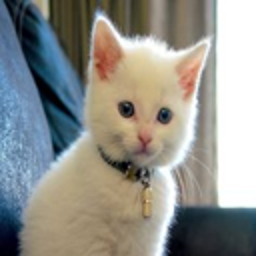

latents (4, 64, 64)              (min -3.9520 / mean -0.3231 / max +1.4818)
(these latents are the same size / scale as SD UNet-generated latents - no extra scale_factor is needed)


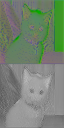

decoded image (3, 256, 256)            (min +0.0000 / mean +0.5657 / max +1.0000)


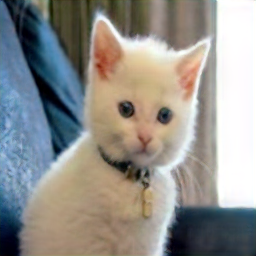

In [3]:
def summarize_tensor(x):
    return f"\033[34m{str(tuple(x.shape)).ljust(24)}\033[0m (\033[31mmin {x.min().item():+.4f}\033[0m / \033[32mmean {x.mean().item():+.4f}\033[0m / \033[33mmax {x.max().item():+.4f}\033[0m)"

def latent_to_visualization(latent):
    latent = TAESD.scale_latents(latent)
    return torch.cat([latent[:3], latent[3:].expand(3, *latent.shape[-2:])], -2)

def demo_taesd_on_image(taesd, image, dev):
    image_raw = TF.to_tensor(image).unsqueeze(0).to(dev)
    image_enc = taesd.encoder(image_raw)
    image_dec = taesd.decoder(image_enc).clamp(0, 1)

    print("input image", summarize_tensor(image_raw[0]))
    display(TF.to_pil_image(image_raw[0]))

    print("latents", summarize_tensor(image_enc[0]))
    print("(these latents are the same size / scale as SD UNet-generated latents - no extra scale_factor is needed)")
    display(TF.to_pil_image(latent_to_visualization(image_enc[0])))

    print("decoded image", summarize_tensor(image_dec[0]))
    display(TF.to_pil_image(image_dec[0]))

demo_taesd_on_image(vae, test_image, dev)

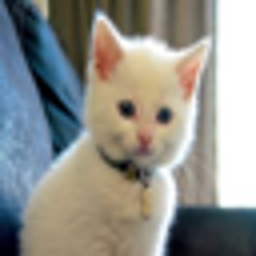

In [4]:
# VAE is better than simple downsample and upsample
low_res_img = Image.open(BytesIO(requests.get(url).content)).convert("RGB").resize((256, 256))
low_res_img64 = low_res_img.resize((64, 64))
low_res_img256 = low_res_img64.resize((256, 256))
low_res_img256

In [5]:
# From https://github.com/CompVis/latent-diffusion

import numpy as np
from einops import rearrange
from taming.modules.vqvae.quantize import VectorQuantizer2 as VectorQuantizer
import pytorch_lightning

def Normalize(in_channels, num_groups=32):
    return torch.nn.GroupNorm(num_groups=num_groups, num_channels=in_channels, eps=1e-6, affine=True)

def nonlinearity(x):
    return x * torch.sigmoid(x)

class Downsample(nn.Module):
    def __init__(self, in_channels, with_conv):
        super().__init__()
        self.with_conv = with_conv
        if self.with_conv:
            # no asymmetric padding in torch conv, must do it ourselves
            self.conv = torch.nn.Conv2d(in_channels,
                                        in_channels,
                                        kernel_size=3,
                                        stride=2,
                                        padding=0)

    def forward(self, x):
        if self.with_conv:
            pad = (0,1,0,1)
            x = torch.nn.functional.pad(x, pad, mode="constant", value=0)
            x = self.conv(x)
        else:
            x = torch.nn.functional.avg_pool2d(x, kernel_size=2, stride=2)
        return x

class Upsample(nn.Module):
    def __init__(self, in_channels, with_conv):
        super().__init__()
        self.with_conv = with_conv
        if self.with_conv:
            self.conv = torch.nn.Conv2d(in_channels,
                                        in_channels,
                                        kernel_size=3,
                                        stride=1,
                                        padding=1)

    def forward(self, x):
        x = torch.nn.functional.interpolate(x, scale_factor=2.0, mode="nearest")
        if self.with_conv:
            x = self.conv(x)
        return x

def make_attn(in_channels, attn_type="vanilla"):
    assert attn_type in ["vanilla", "linear", "none"], f'attn_type {attn_type} unknown'
    print(f"making attention of type '{attn_type}' with {in_channels} in_channels")
    if attn_type == "vanilla":
        return AttnBlock(in_channels)
    elif attn_type == "none":
        return nn.Identity(in_channels)
    else:
        return LinAttnBlock(in_channels)

class LinearAttention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias = False)
        self.to_out = nn.Conv2d(hidden_dim, dim, 1)

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x)
        q, k, v = rearrange(qkv, 'b (qkv heads c) h w -> qkv b heads c (h w)', heads = self.heads, qkv=3)
        k = k.softmax(dim=-1)  
        context = torch.einsum('bhdn,bhen->bhde', k, v)
        out = torch.einsum('bhde,bhdn->bhen', context, q)
        out = rearrange(out, 'b heads c (h w) -> b (heads c) h w', heads=self.heads, h=h, w=w)
        return self.to_out(out)
   

class LinAttnBlock(LinearAttention):
    """to match AttnBlock usage"""
    def __init__(self, in_channels):
        super().__init__(dim=in_channels, heads=1, dim_head=in_channels)


class AttnBlock(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.in_channels = in_channels

        self.norm = Normalize(in_channels)
        self.q = torch.nn.Conv2d(in_channels,
                                 in_channels,
                                 kernel_size=1,
                                 stride=1,
                                 padding=0)
        self.k = torch.nn.Conv2d(in_channels,
                                 in_channels,
                                 kernel_size=1,
                                 stride=1,
                                 padding=0)
        self.v = torch.nn.Conv2d(in_channels,
                                 in_channels,
                                 kernel_size=1,
                                 stride=1,
                                 padding=0)
        self.proj_out = torch.nn.Conv2d(in_channels,
                                        in_channels,
                                        kernel_size=1,
                                        stride=1,
                                        padding=0)


    def forward(self, x):
        h_ = x
        h_ = self.norm(h_)
        q = self.q(h_)
        k = self.k(h_)
        v = self.v(h_)

        # compute attention
        b,c,h,w = q.shape
        q = q.reshape(b,c,h*w)
        q = q.permute(0,2,1)   # b,hw,c
        k = k.reshape(b,c,h*w) # b,c,hw
        w_ = torch.bmm(q,k)     # b,hw,hw    w[b,i,j]=sum_c q[b,i,c]k[b,c,j]
        w_ = w_ * (int(c)**(-0.5))
        w_ = torch.nn.functional.softmax(w_, dim=2)

        # attend to values
        v = v.reshape(b,c,h*w)
        w_ = w_.permute(0,2,1)   # b,hw,hw (first hw of k, second of q)
        h_ = torch.bmm(v,w_)     # b, c,hw (hw of q) h_[b,c,j] = sum_i v[b,c,i] w_[b,i,j]
        h_ = h_.reshape(b,c,h,w)

        h_ = self.proj_out(h_)

        return x+h_

In [73]:
# From https://github.com/CompVis/latent-diffusion

class ResnetBlock(nn.Module):
    def __init__(self, *, in_channels, out_channels=None, conv_shortcut=False,
                 dropout):
        super().__init__()
        self.in_channels = in_channels
        out_channels = in_channels if out_channels is None else out_channels
        self.out_channels = out_channels
        self.use_conv_shortcut = conv_shortcut

        self.norm1 = Normalize(in_channels)
        self.conv1 = torch.nn.Conv2d(in_channels,
                                     out_channels,
                                     kernel_size=3,
                                     stride=1,
                                     padding=1)

        self.norm2 = Normalize(out_channels)
        self.dropout = torch.nn.Dropout(dropout)
        self.conv2 = torch.nn.Conv2d(out_channels,
                                     out_channels,
                                     kernel_size=3,
                                     stride=1,
                                     padding=1)
        if self.in_channels != self.out_channels:
            if self.use_conv_shortcut:
                self.conv_shortcut = torch.nn.Conv2d(in_channels,
                                                     out_channels,
                                                     kernel_size=3,
                                                     stride=1,
                                                     padding=1)
            else:
                self.nin_shortcut = torch.nn.Conv2d(in_channels,
                                                    out_channels,
                                                    kernel_size=1,
                                                    stride=1,
                                                    padding=0)

    def forward(self, x):
        h = x
        h = self.norm1(h)
        h = nonlinearity(h)
        h = self.conv1(h)

        h = self.norm2(h)
        h = nonlinearity(h)
        h = self.dropout(h)
        h = self.conv2(h)

        if self.in_channels != self.out_channels:
            if self.use_conv_shortcut:
                x = self.conv_shortcut(x)
            else:
                x = self.nin_shortcut(x)

        return x+h
    

class Encoder(nn.Module):
    def __init__(self, *, ch, out_ch, ch_mult=(1,2,4,8), num_res_blocks,
                 attn_resolutions, dropout=0.0, resamp_with_conv=True, in_channels,
                 resolution, z_channels, double_z=True, use_linear_attn=False, attn_type="vanilla",
                 embed_dim=3, **ignore_kwargs):
        super().__init__()
        if use_linear_attn: attn_type = "linear"
        self.ch = ch
        self.num_resolutions = len(ch_mult)
        self.num_res_blocks = num_res_blocks
        self.resolution = resolution
        self.in_channels = in_channels

        # downsampling
        self.conv_in = torch.nn.Conv2d(in_channels,
                                       self.ch,
                                       kernel_size=3,
                                       stride=1,
                                       padding=1)

        curr_res = resolution
        in_ch_mult = (1,)+tuple(ch_mult)
        self.in_ch_mult = in_ch_mult
        self.down = nn.ModuleList()
        for i_level in range(self.num_resolutions):
            block = nn.ModuleList()
            attn = nn.ModuleList()
            block_in = ch*in_ch_mult[i_level]
            block_out = ch*ch_mult[i_level]
            for i_block in range(self.num_res_blocks):
                block.append(ResnetBlock(in_channels=block_in,
                                         out_channels=block_out,
                                         dropout=dropout))
                block_in = block_out
                if curr_res in attn_resolutions:
                    attn.append(make_attn(block_in, attn_type=attn_type))
            down = nn.Module()
            down.block = block
            down.attn = attn
            if i_level != self.num_resolutions-1:
                down.downsample = Downsample(block_in, resamp_with_conv)
                curr_res = curr_res // 2
            self.down.append(down)

        # middle
        self.mid = nn.Module()
        self.mid.block_1 = ResnetBlock(in_channels=block_in,
                                       out_channels=block_in,
                                       dropout=dropout)
        self.mid.attn_1 = make_attn(block_in, attn_type=attn_type)
        self.mid.block_2 = ResnetBlock(in_channels=block_in,
                                       out_channels=block_in,
                                       dropout=dropout)

        # end
        self.norm_out = Normalize(block_in)
        self.conv_out = torch.nn.Conv2d(block_in,
                                        2*z_channels if double_z else z_channels,
                                        kernel_size=3,
                                        stride=1,
                                        padding=1)

        self.quant_conv = torch.nn.Conv2d(z_channels, embed_dim, 1)

    def forward(self, x):
        # downsampling
        hs = [self.conv_in(x)]
        for i_level in range(self.num_resolutions):
            for i_block in range(self.num_res_blocks):
                h = self.down[i_level].block[i_block](hs[-1])
                if len(self.down[i_level].attn) > 0:
                    h = self.down[i_level].attn[i_block](h)
                hs.append(h)
            if i_level != self.num_resolutions-1:
                hs.append(self.down[i_level].downsample(hs[-1]))

        # middle
        h = hs[-1]
        h = self.mid.block_1(h)
        h = self.mid.attn_1(h)
        h = self.mid.block_2(h)

        # end
        h = self.norm_out(h)
        h = nonlinearity(h)
        h = self.conv_out(h)

        h = self.quant_conv(h)
        return h
    
    
class Decoder(nn.Module):
    def __init__(self, *, ch, out_ch, ch_mult=(1,2,4,8), num_res_blocks,
                 attn_resolutions, dropout=0.0, resamp_with_conv=True, in_channels,
                 resolution, z_channels, give_pre_end=False, tanh_out=False, use_linear_attn=False,
                 attn_type="vanilla", embed_dim=3, 
                 n_embed=8192, remap=None, sane_index_shape=False, **ignorekwargs):
        super().__init__()
        if use_linear_attn: attn_type = "linear"
        self.ch = ch
        self.num_resolutions = len(ch_mult)
        self.num_res_blocks = num_res_blocks
        self.resolution = resolution
        self.in_channels = in_channels
        self.give_pre_end = give_pre_end
        self.tanh_out = tanh_out
        
        self.n_embed = n_embed
        self.force_quantize = True
        self.quantize = VectorQuantizer(n_embed, embed_dim, beta=0.25,
                                        remap=remap,
                                        sane_index_shape=sane_index_shape)

        self.post_quant_conv = torch.nn.Conv2d(embed_dim, z_channels, 1)
        
        # compute in_ch_mult, block_in and curr_res at lowest res
        in_ch_mult = (1,)+tuple(ch_mult)
        block_in = ch*ch_mult[self.num_resolutions-1]
        curr_res = resolution // 2**(self.num_resolutions-1)
        self.z_shape = (1,z_channels,curr_res,curr_res)
        print("Working with z of shape {} = {} dimensions.".format(
            self.z_shape, np.prod(self.z_shape)))

        # z to block_in
        self.conv_in = torch.nn.Conv2d(z_channels,
                                       block_in,
                                       kernel_size=3,
                                       stride=1,
                                       padding=1)

        # middle
        self.mid = nn.Module()
        self.mid.block_1 = ResnetBlock(in_channels=block_in,
                                       out_channels=block_in,
                                       dropout=dropout)
        self.mid.attn_1 = make_attn(block_in, attn_type=attn_type)
        self.mid.block_2 = ResnetBlock(in_channels=block_in,
                                       out_channels=block_in,
                                       dropout=dropout)

        # upsampling
        self.up = nn.ModuleList()
        for i_level in reversed(range(self.num_resolutions)):
            block = nn.ModuleList()
            attn = nn.ModuleList()
            block_out = ch*ch_mult[i_level]
            for i_block in range(self.num_res_blocks+1):
                block.append(ResnetBlock(in_channels=block_in,
                                         out_channels=block_out,
                                         dropout=dropout))
                block_in = block_out
                if curr_res in attn_resolutions:
                    attn.append(make_attn(block_in, attn_type=attn_type))
            up = nn.Module()
            up.block = block
            up.attn = attn
            if i_level != 0:
                up.upsample = Upsample(block_in, resamp_with_conv)
                curr_res = curr_res * 2
            self.up.insert(0, up) # prepend to get consistent order

        # end
        self.norm_out = Normalize(block_in)
        self.conv_out = torch.nn.Conv2d(block_in,
                                        out_ch,
                                        kernel_size=3,
                                        stride=1,
                                        padding=1)

    def forward(self, z):
        assert z.shape[1:] == self.z_shape[1:]
        self.last_z_shape = z.shape

        if self.force_quantize:
            z, _, _ = self.quantize(z)
        else:
            z = z

        z = self.post_quant_conv(z)
        
        # z to block_in
        h = self.conv_in(z)

        # middle
        h = self.mid.block_1(h)
        h = self.mid.attn_1(h)
        h = self.mid.block_2(h)

        # upsampling
        for i_level in reversed(range(self.num_resolutions)):
            for i_block in range(self.num_res_blocks+1):
                h = self.up[i_level].block[i_block](h)
                if len(self.up[i_level].attn) > 0:
                    h = self.up[i_level].attn[i_block](h)
            if i_level != 0:
                h = self.up[i_level].upsample(h)

        # end
        if self.give_pre_end:
            return h

        h = self.norm_out(h)
        h = nonlinearity(h)
        h = self.conv_out(h)
        if self.tanh_out:
            h = torch.tanh(h)
        
        return h
    

Using device cuda


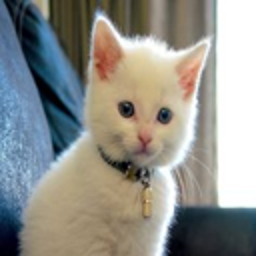

In [74]:
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device", dev)

url = "https://huggingface.co/datasets/hf-internal-testing/diffusers-images/resolve/main/sd2-upscale/low_res_cat.png"
low_res_img = Image.open(BytesIO(requests.get(url).content)).convert("RGB").resize((256, 256))
low_res_img.save('outputs/input_cat.png')
display(low_res_img)
test_image = TF.center_crop(low_res_img, 256)

image_raw = TF.to_tensor(test_image).unsqueeze(0).to(dev)

In [75]:
# Pre-trained weights
attn = False
weights_noattan = torch.load("/home/angelika/vae/pretrained_models/model_vq-f4-noattn.ckpt")
# attn = True
# weights_noattan = torch.load("/home/angelika/vae/pretrained_models/model_vq-f4.ckpt")
attn_type = 'vanilla' if attn else 'none'

In [76]:
# Define latent encoder
encoder3 = Encoder(ch=128, out_ch=3, ch_mult=(1,2,4), num_res_blocks=2,
                attn_resolutions=[], dropout=0.0, resamp_with_conv=True, in_channels=3,
                resolution=256, z_channels=3, double_z=False, 
                use_linear_attn=False, attn_type=attn_type, 
                embed_dim=3)
encoder3 = encoder3.to(dev)

# Define latent decoder
decoder3 = Decoder(ch=128, out_ch=3, ch_mult=(1,2,4), num_res_blocks=2,
                attn_resolutions=[], dropout=0.0, resamp_with_conv=True, in_channels=3,
                resolution=256, z_channels=3, give_pre_end=False, tanh_out=False, 
                use_linear_attn=False, attn_type=attn_type, 
                embed_dim=3, n_embed=8192, remap=None, sane_index_shape=False)
decoder3 = decoder3.to(dev)

making attention of type 'none' with 512 in_channels
Working with z of shape (1, 3, 64, 64) = 12288 dimensions.
making attention of type 'none' with 512 in_channels


In [77]:
new_state_dict = {}
# Load pre-trainded weights into new_state_dict  
for k in encoder3.state_dict():
    if (k != 'quant_conv.weight') and (k != 'quant_conv.bias'):
        new_state_dict.update({k: weights_noattan['state_dict'][f"encoder.{k}"]})

new_state_dict['quant_conv.weight'] = weights_noattan['state_dict']['quant_conv.weight']
new_state_dict['quant_conv.bias'] = weights_noattan['state_dict']['quant_conv.bias']

# Load pre-trainded weights into the encoder
encoder3.load_state_dict(new_state_dict, strict=True)

new_state_dict2 = {}
# Load pre-trainded weights into new_state_dict2  
for k in decoder3.state_dict():
    if (k != 'post_quant_conv.weight') and (k != 'post_quant_conv.bias') and (k != 'quantize.embedding.weight'):
        new_state_dict2.update({k: weights_noattan['state_dict'][f"decoder.{k}"]})

new_state_dict2['post_quant_conv.weight'] = weights_noattan['state_dict']['post_quant_conv.weight']
new_state_dict2['post_quant_conv.bias'] = weights_noattan['state_dict']['post_quant_conv.bias']
new_state_dict2['quantize.embedding.weight'] = weights_noattan['state_dict']['quantize.embedding.weight']

# Load pre-trainded weights into the decoder
decoder3.load_state_dict(new_state_dict2, strict=True)

<All keys matched successfully>

latents (3, 64, 64)              (min +0.0000 / mean +0.6230 / max +1.0000)


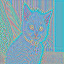

In [78]:
# Encode input image
latent_cat = encoder3(image_raw)
latent_cat_norm = (latent_cat - latent_cat.min()) / (latent_cat.max() - latent_cat.min())
print("latents", summarize_tensor(latent_cat_norm[0]))
latent_cat_im = TF.to_pil_image(latent_cat_norm[0].to(dev))
latent_cat_im.save('outputs/latent_cat.png')
display(TF.to_pil_image(latent_cat_norm[0] * torch.tensor([1, 1, 1])[:, None, None].to(dev)))

decoded image (3, 256, 256)            (min +0.0000 / mean +0.5314 / max +1.0000)


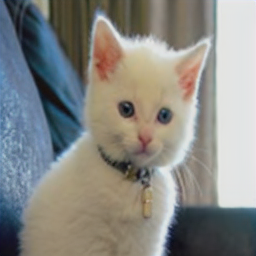

In [79]:
# Decode latent image
decoded_cat = decoder3(latent_cat)
decoded_cat_norm = (decoded_cat - decoded_cat.min()) / (decoded_cat.max() - decoded_cat.min())
print("decoded image", summarize_tensor(decoded_cat_norm[0]))
decoded_cat_im = TF.to_pil_image(decoded_cat_norm[0].to(dev))
decoded_cat_im.save('outputs/decoded_cat.png')
display(TF.to_pil_image(decoded_cat_norm[0] * torch.tensor([1, 1, 1])[:, None, None].to(dev)))

In [80]:
import yaml

config_path = "/home/angelika/vae/configs/config_vq-f4-noattn.yaml"
with open(config_path, 'r') as file:
    config = yaml.safe_load(file)

print(config)

encoder_v2 = Encoder(**config['model']['params']['ddconfig'], **config['model']['params'])
decoder_v2 = Decoder(**config['model']['params']['ddconfig'], **config['model']['params'])

encoder_v2 = encoder_v2.to(dev)
decoder_v2 = decoder_v2.to(dev)

encoder_v2.load_state_dict(new_state_dict, strict=True)
decoder_v2.load_state_dict(new_state_dict2, strict=True)

{'model': {'base_learning_rate': 4.5e-06, 'target': 'ldm.models.autoencoder.VQModel', 'params': {'embed_dim': 3, 'n_embed': 8192, 'monitor': 'val/rec_loss', 'ddconfig': {'attn_type': 'none', 'double_z': False, 'z_channels': 3, 'resolution': 256, 'in_channels': 3, 'out_ch': 3, 'ch': 128, 'ch_mult': [1, 2, 4], 'num_res_blocks': 2, 'attn_resolutions': [], 'dropout': 0.0}, 'lossconfig': {'target': 'taming.modules.losses.vqperceptual.VQLPIPSWithDiscriminator', 'params': {'disc_conditional': False, 'disc_in_channels': 3, 'disc_start': 11, 'disc_weight': 0.75, 'codebook_weight': 1.0}}}}, 'data': {'target': 'main.DataModuleFromConfig', 'params': {'batch_size': 8, 'num_workers': 12, 'wrap': True, 'train': {'target': 'ldm.data.openimages.FullOpenImagesTrain', 'params': {'crop_size': 256}}, 'validation': {'target': 'ldm.data.openimages.FullOpenImagesValidation', 'params': {'crop_size': 256}}}}}
making attention of type 'none' with 512 in_channels
Working with z of shape (1, 3, 64, 64) = 12288 dim

latents (3, 64, 64)              (min +0.0000 / mean +0.6230 / max +1.0000)


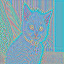

In [88]:
# Encode input image
latent_cat = encoder_v2(image_raw)

latent_cat_norm = (latent_cat - latent_cat.min()) / (latent_cat.max() - latent_cat.min())
print("latents", summarize_tensor(latent_cat_norm[0]))
latent_cat_im = TF.to_pil_image(latent_cat_norm[0].to(dev))
latent_cat_im.save('outputs/latent_cat.png')
display(TF.to_pil_image(latent_cat_norm[0] * torch.tensor([1, 1, 1])[:, None, None].to(dev)))

decoded image (3, 256, 256)            (min +0.0000 / mean +0.5314 / max +1.0000)


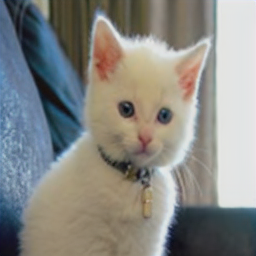

In [89]:
# Decode latent image
decoded_cat = decoder_v2(latent_cat)
decoded_cat_norm = (decoded_cat - decoded_cat.min()) / (decoded_cat.max() - decoded_cat.min())
print("decoded image", summarize_tensor(decoded_cat_norm[0]))
decoded_cat_im = TF.to_pil_image(decoded_cat_norm[0].to(dev))
decoded_cat_im.save('outputs/decoded_cat.png')
display(TF.to_pil_image(decoded_cat_norm[0] * torch.tensor([1, 1, 1])[:, None, None].to(dev)))